## Overview: Property prediction model from scraped airbnb data

* combine data sets from 3 cities with feature column 'city'
* Make baseline model by predicting the city's average and calculating RMSE
* Improve baseline by adding features to linear regression model and calculate improvement
* calculate RMSE of model over different sizes of training examples to see improvement

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_df(df_file):
    basepath = 'data/'
    filepath = basepath + df_file
    load_df = pd.DataFrame.from_csv(filepath)
    return load_df

In [3]:
# load the processed datasets (from case-study-explore)
ny_df = load_df('processed_ny_df.csv')
la_df = load_df('processed_la_df.csv')
sf_df = load_df('processed_sf_df.csv')

In [4]:
ny_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating
0,1,2,6882689,198,Apartment,17,2,5
1,2,7,12022627,2200,Apartment,0,2,0
2,1,2,8940740,149,Apartment,6,2,5
3,1,4,12035970,55,Apartment,0,2,0
4,1,2,11642165,65,Apartment,3,1,5


In [76]:
def preprocess_data(df):
    """Take in df and map/dummify object columns"""

    # process non-numeric data types
    df['Room_Type'] = df.Room_Type.map({'Shared room':0,'Private room':1, 'Entire home/apt':2})

    # get_dummies for Property_Type, initially was going to do, but not enough non-Apartments
    #temp_df pd.get_dummies(df.Property_Type, prefix='Ptype')  # e.g. 'Property_Type' => 'Ptype_Apartment'
    #df = pd.concat([df, temp_df])

    return df 

In [77]:
sf_df = preprocess_data(sf_df)

In [18]:
gb = ny_df.groupby('Star_Rating').Price.mean()
gb

Star_Rating
0.0    125.722892
4.0     66.500000
4.5     93.458824
5.0     99.825758
Name: Price, dtype: float64

In [20]:
gb2 = ny_df.groupby('Capacity').Price.mean()
gb2

Capacity
1      58.303571
2      94.967033
3     138.827586
4     130.848485
5     102.000000
6     135.000000
7    2200.000000
8     245.000000
Name: Price, dtype: float64

In [22]:
gb3 = ny_df.groupby('Room_Type').Price.mean()
gb3

Room_Type
0     49.333333
1     70.538462
2    143.437500
Name: Price, dtype: float64

In [65]:
gb4 = ny_df.groupby('Bedrooms').Price.mean()
gb4

Bedrooms
0    126.462963
1     88.087866
2    321.500000
3    215.000000
Name: Price, dtype: float64

In [78]:
ny_df['City'] = 'NY'

In [24]:
ny_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City
0,1,2,6882689,198,Apartment,17,2,5,NY
1,2,7,12022627,2200,Apartment,0,2,0,NY
2,1,2,8940740,149,Apartment,6,2,5,NY
3,1,4,12035970,55,Apartment,0,2,0,NY
4,1,2,11642165,65,Apartment,3,1,5,NY


In [79]:
la_df['City'] = 'LA'
sf_df['City'] = 'SF'

In [80]:
ny_df['Avg_Price'] = ny_df.Price.mean()

In [81]:
la_df['Avg_Price'] = la_df.Price.mean()
sf_df['Avg_Price'] = sf_df.Price.mean()

In [82]:
def combine_dfs(df_list):
    data_frame = None
    for df in df_list:
        if data_frame is None:
            data_frame = df
        else:
            data_frame = data_frame.append(df)
    return data_frame

In [83]:
df_list = [ny_df, la_df, sf_df]
combined_df = combine_dfs(df_list)

In [49]:
combined_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City,Avg_Price
0,1,2,6882689,198,Apartment,17,2,5,NY,104.428105
1,2,7,12022627,2200,Apartment,0,2,0,NY,104.428105
2,1,2,8940740,149,Apartment,6,2,5,NY,104.428105
3,1,4,12035970,55,Apartment,0,2,0,NY,104.428105
4,1,2,11642165,65,Apartment,3,1,5,NY,104.428105


In [84]:
# remove that outlier
combined_df = combined_df[combined_df.Price<2000]

In [51]:
combined_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City,Avg_Price
0,1,2,6882689,198,Apartment,17,2,5.0,NY,104.428105
2,1,2,8940740,149,Apartment,6,2,5.0,NY,104.428105
3,1,4,12035970,55,Apartment,0,2,0.0,NY,104.428105
4,1,2,11642165,65,Apartment,3,1,5.0,NY,104.428105
5,1,1,648047,61,Apartment,66,1,4.5,NY,104.428105


# Baseline model where prediction = Average Price for a given city

In [58]:
from sklearn import metrics

In [56]:
base_predictions = np.log(combined_df.Avg_Price)

In [59]:
y = np.log(combined_df.Price)

In [60]:
error = y - base_predictions

In [94]:
base_r2 = metrics.r2_score(y, base_predictions)
base_r2

0.022980756866397445

### Baseline r^2 is 0.02298, we will build linear regression model that beats this value.

In [63]:
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split

In [85]:
# One hot encode 'City' feature
# create three dummy variables using get_dummies, then exclude the first dummy column
city_dummies = pd.get_dummies(combined_df.City, prefix='City').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame
combined_df = pd.concat([combined_df, city_dummies], axis=1)
combined_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City,Avg_Price,City_NY,City_SF
0,1,2,6882689,198,Apartment,17,2,5.0,NY,104.428105,1,0
2,1,2,8940740,149,Apartment,6,2,5.0,NY,104.428105,1,0
3,1,4,12035970,55,Apartment,0,2,0.0,NY,104.428105,1,0
4,1,2,11642165,65,Apartment,3,1,5.0,NY,104.428105,1,0
5,1,1,648047,61,Apartment,66,1,4.5,NY,104.428105,1,0


In [86]:
# add log of Price and Capacity since skewed distributions
combined_df['log_Capacity'] = np.log(combined_df.Capacity)
combined_df['log_Price'] = np.log(combined_df.Price)

In [67]:
combined_df.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City,Avg_Price,City_NY,City_SF,log_Capacity,log_Price
0,1,2,6882689,198,Apartment,17,2,5.0,NY,104.428105,1,0,0.693147,5.288267
2,1,2,8940740,149,Apartment,6,2,5.0,NY,104.428105,1,0,0.693147,5.003946
3,1,4,12035970,55,Apartment,0,2,0.0,NY,104.428105,1,0,1.386294,4.007333
4,1,2,11642165,65,Apartment,3,1,5.0,NY,104.428105,1,0,0.693147,4.174387
5,1,1,648047,61,Apartment,66,1,4.5,NY,104.428105,1,0,0.000000,4.110874


In [87]:
feature_cols = ['log_Capacity','City_SF','City_NY','Room_Type']
X = combined_df[feature_cols]
y = combined_df.log_Price

In [88]:
# make training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [89]:
lr_ridge = Ridge()

In [90]:
lr_ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [91]:
predictions = lr_ridge.predict(X_test)

In [92]:
ridge_RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
ridge_RMSE

0.32120395686993414

In [99]:
ridge_r2 = metrics.r2_score(y_test, predictions)
ridge_r2

0.54006802837202805

In [101]:
# Let's take a look at the residuals
resids = y_test - predictions

/Users/paulsingman/pyth/data-analysis/venv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


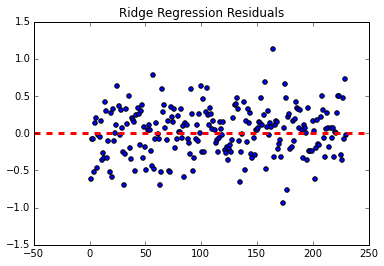

In [104]:
plt.scatter(np.linspace(1,230,230),resids)
plt.axhline(ls='--', linewidth=3, color='r')
plt.title('Ridge Regression Residuals')

### Residuals look like random noise (good) and are homoscedastic

### With the ridge model we achieve an r-squared of .54. Let's try to optimize the alpha parameter to improve this value

In [100]:
alphas = [10e-3, 10e-2, 10e-1, 1, 10, 100]

In [105]:
RMSEs = []
r_squareds = []
for a in alphas:
    lr_ridge = Ridge(alpha=a)
    lr_ridge.fit(X_train, y_train)
    predictions = lr_ridge.predict(X_test)
    RMSEs.append(np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    r_squareds.append(metrics.r2_score(y_test, predictions))
    

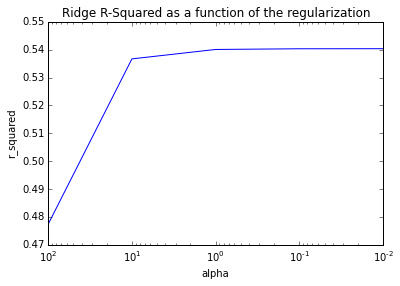

In [109]:
ax = plt.gca()

ax.plot(alphas, r_squareds)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('r_squared')
plt.title('Ridge R-Squared as a function of the regularization')
plt.show()

#### Graph shows that alpha of 1 is reasonably optimal.

# For comparison to the linear model, let's try a Gradient Boosted Regressor
### We'll use grid search to find the optimal parameters and score it by the RMSE

In [110]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV

In [111]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 1],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9]
              }

gbr = GradientBoostingRegressor(n_estimators=1500)

gs_cv = GridSearchCV(gbr, param_grid, n_jobs=4).fit(X_train, y_train)

In [112]:
# best parameters
gs_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 5}

In [113]:
gs_cv.best_score_

0.57007229401371318

In [ ]:
mae = mean_absolute_error(y_test, est.predict(X_test))
print('MAE: %.4f' % mae)

In [115]:
opt_gbr = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.01, max_depth=4, min_samples_leaf=5)

In [116]:
opt_gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=5000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [117]:
gbr_rmse = np.sqrt(metrics.mean_squared_error(y_test, opt_gbr.predict(X_test)))
gbr_rmse

0.32653518322187269